In [1]:
import os
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchmetrics import (
    Accuracy,
    MetricCollection,
    JaccardIndex,
    F1Score,
    MeanSquaredError,
)
import segmentation_models_pytorch as smp
from pytorch_toolbelt.losses import JaccardLoss, BinaryFocalLoss
from torch.utils.data import Dataset, random_split, DataLoader

from pytorch_lightning import Trainer
from typing import Any, Tuple, Optional, Callable, cast

import matplotlib.pyplot as plt
import wandb
import tqdm as notebook_tqdm
import random

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [3]:
import segmentation_models_pytorch as smp

In [4]:
pl.seed_everything(27)

Global seed set to 27


27

In [5]:
wandb.login()

wandb: Currently logged in as: sofstef (trees). Use `wandb login --relogin` to force relogin


True

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
%load_ext lab_black

In [8]:
os.chdir("/Users/sofija/Ai4er/mres/tree-segmentation")
os.getcwd()

'/Users/sofija/Ai4er/mres/tree-segmentation'

In [9]:
from src.datasets import TreeSegments
from src.evaluation import BinaryIoU
from src.datamodules import TreeDataModule
from src.models import UNet, SegModel
from src.evaluation import LogPredictionSamplesCallback

In [10]:
dm = TreeDataModule(
    data_dir="data/raw/samples/",
    target_dir="data/segments/",
    test_data_dir="data/test_samples",
    test_target_dir="data/test_segments/",
    batch_size=8,
    num_workers=0,
    drop_last_batch=True,
)

In [11]:
dm.setup(stage="fit")
train_dl = dm.train_dataloader()

In [12]:
dm.setup(stage="test")
test_dl = dm.test_dataloader()

In [14]:
for sample in train_dl:
    image = sample[0]
    mask = sample[1]

In [13]:
for sample in test_dl:
    image = sample[0]
    mask = sample[1]

In [13]:
mask.max()

tensor(1)

In [14]:
image.dtype

torch.float32

In [15]:
image.shape

torch.Size([7, 1, 128, 160])

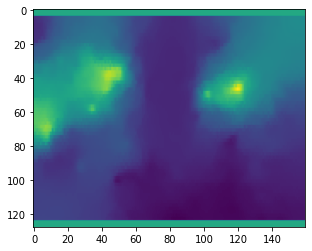

In [16]:
plt.imshow(torch.squeeze(image[3, :, :]))

## Loading model from a checkpoint


In [20]:
# callbacks = [
#     ModelCheckpoint(monitor="test_accuracy", mode="max"),
#     ModelCheckpoint(monitor="test_jaccard", mode="max"),
#     ModelCheckpoint(monitor="test_loss", mode="min", save_top_k=2),
#     ModelCheckpoint(monitor="test_f1", mode="max"),
# ]

In [21]:
best_path = "lightning_logs/colab_ckpt/epoch=78-step=632-v1.ckpt"

In [22]:
trained_model = SegModel.load_from_checkpoint(checkpoint_path=best_path)

In [23]:
trainer = Trainer()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
tests = trainer.test(model=trained_model, dataloaders=dm)

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7719748020172119
         test_f1            0.8246610164642334
      test_jaccard          0.8100916147232056
        test_loss           0.17516586184501648
        test_rmse               0.068359375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [25]:
tests

[{'test_loss': 0.17516586184501648,
  'test_accuracy': 0.7719748020172119,
  'test_jaccard': 0.8100916147232056,
  'test_f1': 0.8246610164642334,
  'test_rmse': 0.068359375}]

### Inspecting test predictions

First, let's plot the input images and masks from the test dataset alongside predictions from the model trained on 80 samples. 

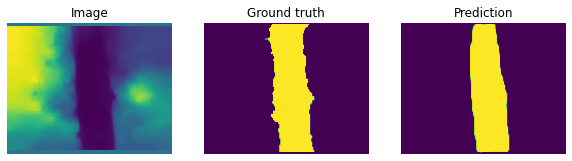

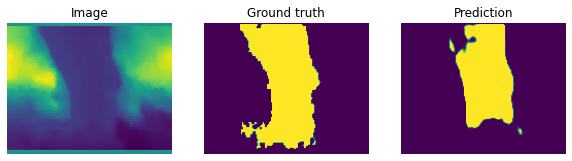

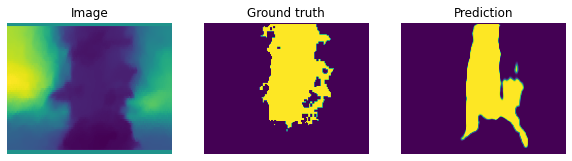

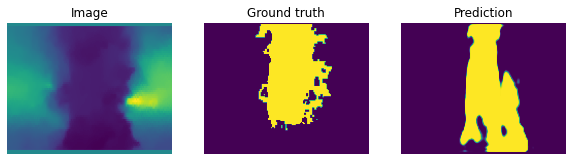

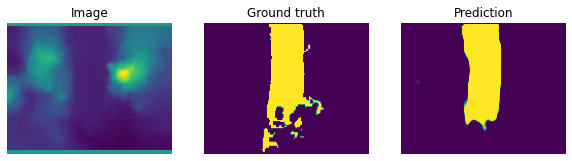

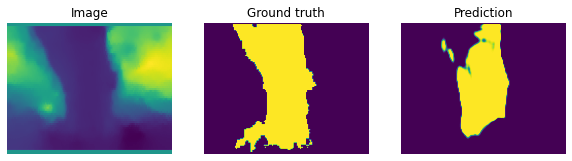

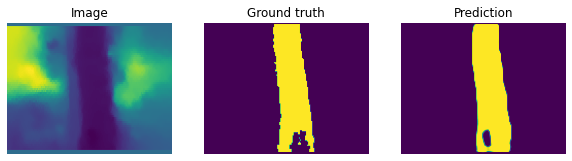

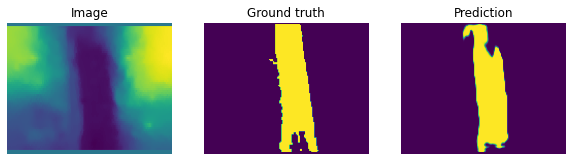

In [26]:
batch = next(iter(test_dl))
with torch.no_grad():
    trained_model.eval()
    logits = trained_model(batch[0])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(torch.squeeze(image))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(torch.squeeze(gt_mask))
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(torch.squeeze(pr_mask))
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

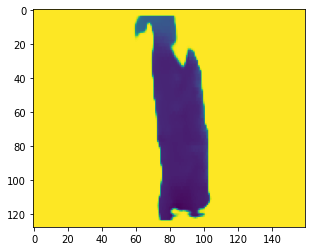

In [34]:
overlay = image * pr_mask

plt.imshow(torch.squeeze(overlay))
plt.savefig("overlay_example.png")

RMSE computation

In [68]:
mean_sq_error = MeanSquaredError()
rmse_example = mean_sq_error(pr_mask, gt_mask)

In [75]:
rmse_example

tensor(0.0429)

In [73]:
rmse_tests = np.zeros(7)

n = 0
for pred, target in zip(trained_model.test_preds, trained_model.test_gtruth):
    rmse = mean_sq_error(pred, target)
    rmse_tests[n] = rmse
    n += 1

In [74]:
rmse_tests

array([0.03310547, 0.1359375 , 0.03789062, 0.04082031, 0.11298828,
       0.01679688, 0.01630859])

In [ ]:
pred = trained_model.test_preds[0]


### Inspecting prediction

Automatically auto-loads the best weights from the previous run

```
predictions = trainer.predict(dataloaders=predict_dataloader)
```
Or call with pretrained model
```
model = MyLightningModule.load_from_checkpoint(PATH)
trainer = Trainer()
predictions = trainer.predict(model, dataloaders=test_dataloader)
```

In [27]:
dm.setup(stage="predict")

In [28]:
predict_dl = dm.predict_dataloader()

In [29]:
# currently in my predict dataloader I have only the inputs
# so below where I plot I pick the corresponding mask by hand

for sample in predict_dl:
    gtruth = sample[0]

In [30]:
gtruth.shape

torch.Size([1, 128, 160])

In [31]:
test_predict = trainer.predict(trained_model, predict_dl)

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|█████████████████████████████████████| 11/11 [00:04<00:00,  2.48it/s]


In [32]:
len(test_predict)

11

In [76]:
wandb.finish()